In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import math
import torch
import matplotlib.pyplot as plt

# install instructions here https://github.com/nicola-decao/power_spherical
from power_spherical import PowerSpherical

In [3]:
# here we create a PowerSpherical distribution with n_clusters locations around the unit circle
n_clusters = 5

dist = PowerSpherical(
    loc=torch.tensor([
      [
          math.cos(2 * torch.pi * i / n_clusters),
          math.sin(2 * torch.pi * i / n_clusters)
      ]
      for i in range(n_clusters)
    ]),
    scale=torch.tensor([500. for _ in range(n_clusters)]),
)

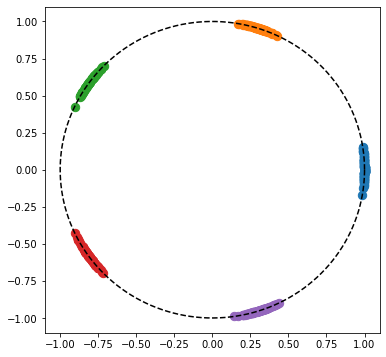

In [4]:
# here we sample from the distributions and we plot it
plt.figure(figsize=(6,6))
t = torch.linspace(0, 2 * torch.pi, 1000)
plt.plot(torch.cos(t), torch.sin(t), "--", color="black")

samples = dist.sample((100,))
for e in samples.transpose(0, 1):
    plt.scatter(*e.T, s=70)

In [5]:
# creates a random projection of dimensionality dim and adds gaussian noise
def random_proj(x, dim=100, noise=0.05):
    return torch.nn.Linear(2, dim, bias=False)(x) + torch.randn(x.shape[:-1] + (dim,)) * noise

projected_samples = random_proj(samples).flatten(0, 1)

In [6]:
# lets how well we can reconstruct with k_components
svd = projected_samples.svd()
k_components = 2
svd.U * (svd.S * (svd.S >= svd.S.topk(k_components).values[-1]).float()) @ svd.V.T, projected_samples

(tensor([[-0.6711, -0.6011,  0.6582,  ..., -0.6548, -0.2338,  0.1905],
         [-0.8046,  0.1245,  0.0348,  ..., -0.3453,  0.5642,  0.0953],
         [ 0.1453,  0.6890, -0.6412,  ...,  0.4325,  0.6090, -0.1292],
         ...,
         [ 0.2027,  0.7003, -0.6618,  ...,  0.4677,  0.5891, -0.1392],
         [ 0.8765,  0.3627, -0.4826,  ...,  0.6354, -0.1167, -0.1823],
         [ 0.4834, -0.4614,  0.3240,  ...,  0.0064, -0.7253,  0.0036]],
        grad_fn=<MmBackward0>),
 tensor([[-0.6711, -0.4966,  0.5778,  ..., -0.7148, -0.3004,  0.2349],
         [-0.8203,  0.0916,  0.0310,  ..., -0.3237,  0.5409,  0.1023],
         [ 0.1473,  0.6934, -0.6295,  ...,  0.4598,  0.6314, -0.1330],
         ...,
         [ 0.2435,  0.6647, -0.6411,  ...,  0.4204,  0.6015, -0.1352],
         [ 0.8302,  0.3638, -0.5201,  ...,  0.6335, -0.0770, -0.2137],
         [ 0.4632, -0.4760,  0.4003,  ..., -0.0014, -0.7313, -0.0115]],
        grad_fn=<ReshapeAliasBackward0>))

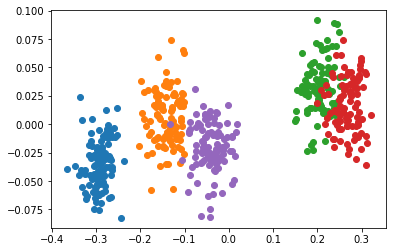

In [7]:
# let's plot PCA with 2 dim
for e in projected_samples.view(100, 5, -1).transpose(0, 1):
    plt.scatter(*(e @ svd.U[:k_components].T).T.detach())